In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Сгенерируйте данные с помощью кода

In [2]:
from sklearn.datasets import make_classification
x_data_generated, y_data_generated = make_classification(scale=1, random_state=9)

In [3]:
print('Features shape:', x_data_generated.shape)
print('Target counts:', np.unique(y_data_generated, return_counts=True))

Features shape: (100, 20)
Target counts: (array([0, 1]), array([51, 49], dtype=int64))


### 2. Постройте модель логистической регрессии и оцените среднюю точность

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

results = pd.DataFrame(columns=['selection_method', 'no_of_features', 'mean_accuracy_score'])

def to_results(x, method_name):
    no_of_features = x.shape[1]
    score = cross_val_score(LogisticRegression(), x, y_data_generated, scoring='accuracy').mean()
    results.loc[len(results)] = [method_name, no_of_features, score]
    return results

In [5]:
to_results(x_data_generated, 'Without selection')

,selection_method,no_of_features,mean_accuracy_score
0,Without selection,20,0.86


### 3. Используйте статистические методы для отбора признаков:
- a) Выберите признаки на основе матрицы корреляции.
- b) Отсеките низковариативные признаки (VarianceThreshold).
- c) Повторите п. 2 на отобранных признаках в п. 3a, п. 3b.

In [6]:
df = pd.DataFrame(x_data_generated)
df['target'] = y_data_generated
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,target
0,-0.061000,-0.868975,0.043621,-2.757511,-1.304449,0.074567,-1.990860,-1.336837,-0.486052,0.954555,...,0.769176,1.529572,0.338366,-2.621578,1.159243,0.956275,-0.437646,0.347415,0.476281,1
1,-1.058712,-1.282205,0.167144,0.144471,-0.861473,0.158882,1.756368,-1.897736,-0.651007,0.337486,...,0.915471,-1.796172,1.798489,-0.541945,0.236401,-0.176654,-0.503043,-1.063231,-0.854900,1
2,1.101442,-1.398838,-0.583313,0.137913,1.249654,1.336861,-0.715492,0.029136,-0.058943,0.337582,...,1.100319,-0.936254,1.818105,1.387800,0.430021,0.341622,-0.609006,-0.914463,1.141516,1
3,0.267982,0.357477,-1.460234,-0.544337,-1.042708,0.319371,0.367953,0.152713,-1.500331,1.182636,...,0.219119,1.275841,2.415371,-0.128888,-0.622297,-1.067046,-0.095031,-2.354515,-0.044146,0
4,-0.621145,0.470908,0.158531,1.003873,0.371210,0.121555,-1.006374,-0.274246,-0.124201,0.668889,...,0.075988,-0.152468,1.226548,0.796282,1.754514,-1.301110,-0.027984,-1.228003,2.252981,0


**Создаю матрицу корреляции и отбираю признаки, коэффициент корреляции которых с целевой переменной более или равен `0.1`**

In [7]:
corr_matrix = df.corr()
corr_matrix.target

0         0.161469
1        -0.113391
2        -0.088631
3        -0.058947
4        -0.066213
5         0.136104
6         0.074869
7        -0.062309
8        -0.030969
9        -0.065364
10       -0.163456
11        0.776704
12       -0.027492
13        0.493303
14        0.093541
15       -0.125132
16        0.016228
17       -0.777922
18        0.002078
19       -0.045429
target    1.000000
Name: target, dtype: float64

In [8]:
features_by_corr = list(corr_matrix.target[np.abs(corr_matrix.target) >= 0.1].index)
features_by_corr

[0, 1, 5, 10, 11, 13, 15, 17, 'target']

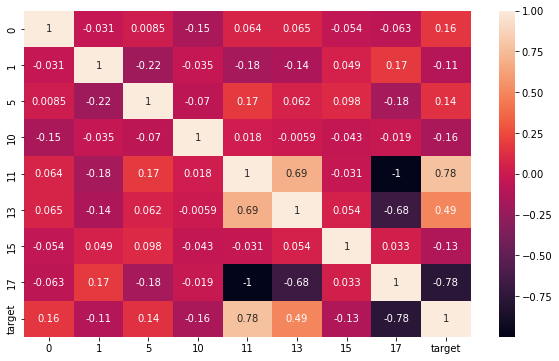

In [9]:
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix[features_by_corr].loc[features_by_corr], annot=True)
plt.show()

**На тепловой карте видно, что есть два признака максимально скоррелированных между собой: `11` и `17`. Необходимо избавиться от одного из них**

In [10]:
del features_by_corr[-2:]
features_by_corr

[0, 1, 5, 10, 11, 13, 15]

In [11]:
x = x_data_generated.T[features_by_corr].T

to_results(x, 'Correlation matrix')

,selection_method,no_of_features,mean_accuracy_score
0,Without selection,20,0.86
1,Correlation matrix,7,0.89


**Отсеку признаки, дисперсия которых ниже средней дисперсии по всему набору признаков**

In [12]:
from sklearn.feature_selection import VarianceThreshold

x = VarianceThreshold(x_data_generated.var()).fit_transform(x_data_generated)

to_results(x, 'Variance threshold')

,selection_method,no_of_features,mean_accuracy_score
0,Without selection,20,0.86
1,Correlation matrix,7,0.89
2,Variance threshold,5,0.91


### 4. Осуществите отбор признаков на основе дисперсионного анализа:
- a) Выберите 5 лучших признаков с помощью скоринговой функции для классификации f_classif (SelectKBest(f_classif, k=5)).
- b) Повторите п. 2 на отобранных признаках.

In [13]:
from sklearn.feature_selection import SelectKBest

x = SelectKBest(k=5).fit_transform(x_data_generated, y_data_generated)

to_results(x, 'Analysis of variance')

,selection_method,no_of_features,mean_accuracy_score
0,Without selection,20,0.86
1,Correlation matrix,7,0.89
2,Variance threshold,5,0.91
3,Analysis of variance,5,0.89


### 5. Отбор с использованием моделей:
- a) Реализуйте отбор признаков с помощью логистической регрессии. Отобранные признаки подайте далее на вход в саму логистическую регрессию (SelectFromModel). Используйте L1 регуляризацию.
- b) Реализуйте отбор признаков с помощью модели RandomForest и встроенного атрибута feature_impotance.
- c) Повторите п. 2 на отобранных признаках в п. 5a, п. 5b.

**Я установил параметр `C=0.2` для большей силы регуляризации, чтобы было отобрано меньшее количество признаков**

In [14]:
from sklearn.feature_selection import SelectFromModel

estimator = LogisticRegression(penalty='l1', solver='liblinear', C=0.2)
x = SelectFromModel(estimator).fit_transform(x_data_generated, y_data_generated)

to_results(x, 'Lasso logistic regression')

,selection_method,no_of_features,mean_accuracy_score
0,Without selection,20,0.86
1,Correlation matrix,7,0.89
2,Variance threshold,5,0.91
3,Analysis of variance,5,0.89
4,Lasso logistic regression,4,0.91


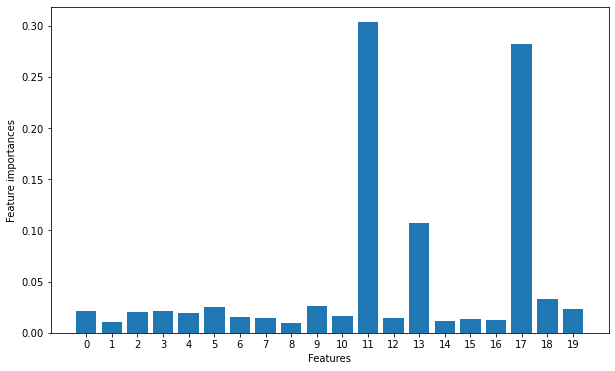

In [15]:
from sklearn.ensemble import RandomForestClassifier

features_score = RandomForestClassifier(random_state=42).fit(x_data_generated, y_data_generated).feature_importances_

plt.figure(figsize=(10,6))
plt.bar(range(20), features_score)
plt.xticks(range(20))
plt.xlabel('Features')
plt.ylabel('Feature importances')
plt.show()

**Наиболее важными признаками случайный лес признал `11`, `13` и `17`. Но как было выяснено ранее при рассмотрении корреляционной матрицы, признаки `11` и `17` скоррелированы с максимальным коэффициентом `1`, поэтому я оставлю лишь два признака `11` и `13`**

In [16]:
x = x_data_generated.T[[11, 13]].T

to_results(x, 'Random forest')

,selection_method,no_of_features,mean_accuracy_score
0,Without selection,20,0.86
1,Correlation matrix,7,0.89
2,Variance threshold,5,0.91
3,Analysis of variance,5,0.89
4,Lasso logistic regression,4,0.91
5,Random forest,2,0.90


### 6. Перебор признаков:
- a) SequentialFeatureSelector.
- b) Повторите п. 2 на отобранных признаках.

**Похоже, что двух признаков должно быть достаточно для того, чтобы добиться точности не менее 90%. Попрошу SequentialFeatureSelector оставить только два признака**

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector

x = SequentialFeatureSelector(LogisticRegression(), n_features_to_select=2).fit_transform(x_data_generated, y_data_generated)

to_results(x, 'Sequential Feature Selector')

,selection_method,no_of_features,mean_accuracy_score
0,Without selection,20,0.86
1,Correlation matrix,7,0.89
2,Variance threshold,5,0.91
3,Analysis of variance,5,0.89
4,Lasso logistic regression,4,0.91
5,Random forest,2,0.90
6,Sequential Feature Selector,2,0.93


### 7. Сформулируйте выводы по проделанной работе:

На мой взгляд при должной настройке с помощью любого из рассмотренных методов можно достичь желаемого результата. Необходимо учитывать специфику данных при выборе метода. К примеру, в моем случае оказалось достаточно всего двух признаков, чтобы добиться максимальной точности классификации, не прибегая к другим методам, кроме отбора признаков.

В такой ситуации, когда данных и признаков относительно немного, `Sequential Feature Selector` может сработать быстрее и качественнее других методов, поскольку он просто переберет все возможные варианты и выдаст оптимальный. Необходимо только определиться с тем сколько признаков оставить. Но и это решение можно делегировать `SFS`, установив для параметра `n_features_to_select` значение `auto`.